In [31]:
#auto reload jupyter to update notebook w.r.t changes in other linked files:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
#from xgboost.testing import root_mean_square
import shap

import logging
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


from train_and_evaluate_sklearn import load_train_test_data
from preprocessing import preprocess_data, train_test_split

In [33]:
#Set logging config
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

In [34]:
#Define the predictand
predictands = 'lwp'  # choose - 'both' for multitarget prediction and 'clf'/ 'lwp', for either of the single target prediction.

df_preprocessed, predictors, predictands = (preprocess_data
    (
        scalertype='minmax', #best performance 'minmax' scaler
        outlier_method=None, #best performance 'iqr' outlier method
        scale_predictands=True,
        selected_predictands=predictands,
  ))
#df_train, df_test, X_train, y_train, X_test, y_test, predictors, predictands = load_train_test_data(predictands=predictands)


Preprocessed data returned.
 Scaled Data: minmax scaler applied.
 Outlier removal method: None.
 Predictands: ['lwp']


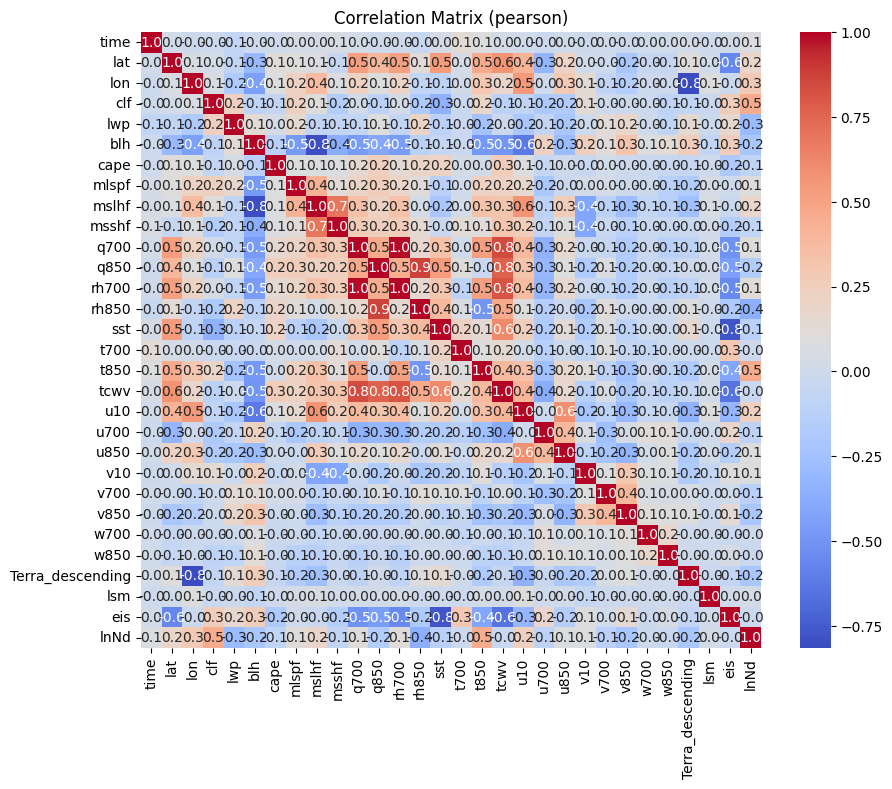

Pairs with |correlation| > 0.7:
lon & Terra_descending: -0.81
blh & mslhf: -0.80
q700 & rh700: 0.99
q700 & tcwv: 0.84
q850 & rh850: 0.87
q850 & tcwv: 0.77
rh700 & tcwv: 0.81
sst & eis: -0.77


In [35]:
from preprocessing import compute_correlation
compute_correlation(df_preprocessed, include_predictands=True)

In [36]:
#REMOVE (SOME) CORRELATED PREDICTORS
# df_preprocessed=df_preprocessed.drop(columns=['mslhf','rh700','rh850','tcwv'])
#
#
# predictors = [col for col in df_preprocessed.columns if col not in ['clf','lwp','time', 'lat', 'lon', 'cat','dog']]


In [37]:

df_train, df_test, X_train, y_train, X_test, y_test = train_test_split(
    df_preprocessed=df_preprocessed,
    predictors=predictors,
    predictands=predictands,
    train_fraction=0.75
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Convert pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f'train_loader: {train_loader} \n test_loader: {test_loader}' )
print(f'size of train_loader: {len(train_loader)} \n size of test_loader: {len(test_loader)}')

X_train shape: (197145, 25), y_train shape: (197145, 1)
train_loader: <torch.utils.data.dataloader.DataLoader object at 0x72c3c9e003d0> 
 test_loader: <torch.utils.data.dataloader.DataLoader object at 0x72c3c04eda90>
size of train_loader: 3081 
 size of test_loader: 949


Neural Network Architecture

In [38]:
class MultiTargetRegressor(nn.Module):
    """Neural network for multi-target regression"""
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            # Input layer to first hidden layer
            nn.Linear(input_size, 32),
            nn.ReLU(),

            # First hidden layer to second hidden layer
            nn.Linear(32, 16),
            nn.ReLU(),

            # second hidden layer to third hidden layer
            nn.Linear(16, 10),
            nn.ReLU(),

            # third hidden layer to output layer
            nn.Linear(10, output_size)
        )

        # Initialize weights using Kaiming He initialization for ReLU
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        """Defines forward pass through network"""
        return self.layers(x)

Model Training Function:

In [39]:
def train_model(model, train_loader, test_loader, num_epochs=100):
    """Training loop with validation monitoring"""
    # Loss function and optimizer
    learning_rate = 0.005
    #loss_function = nn.MSELoss()
    loss_function = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

    # Track losses for visualization
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(X_batch)  # Forward pass
            loss = loss_function(outputs, y_batch)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            epoch_train_loss += loss.item()

        # Validation phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = loss_function(outputs, y_batch)
                epoch_val_loss += loss.item()

        # Calculate average losses
        train_loss = epoch_train_loss / len(train_loader)
        val_loss = epoch_val_loss / len(test_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Update learning rate
        scheduler.step(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}')

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

    return train_losses, val_losses


In [40]:
#TIME CONSUMING STEP
#Model Training

input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MultiTargetRegressor(input_size, output_size)

# Train model
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=30
)

Epoch 1/30 | Train Loss: 0.0047 | Val Loss: 0.0037 | LR: 0.005000
Epoch 1/30 | Train Loss: 0.0047 | Val Loss: 0.0037
Epoch 2/30 | Train Loss: 0.0043 | Val Loss: 0.0037 | LR: 0.005000
Epoch 2/30 | Train Loss: 0.0043 | Val Loss: 0.0037
Epoch 3/30 | Train Loss: 0.0042 | Val Loss: 0.0035 | LR: 0.005000
Epoch 3/30 | Train Loss: 0.0042 | Val Loss: 0.0035
Epoch 4/30 | Train Loss: 0.0041 | Val Loss: 0.0035 | LR: 0.005000
Epoch 4/30 | Train Loss: 0.0041 | Val Loss: 0.0035
Epoch 5/30 | Train Loss: 0.0041 | Val Loss: 0.0035 | LR: 0.005000
Epoch 5/30 | Train Loss: 0.0041 | Val Loss: 0.0035
Epoch 6/30 | Train Loss: 0.0041 | Val Loss: 0.0035 | LR: 0.005000
Epoch 6/30 | Train Loss: 0.0041 | Val Loss: 0.0035
Epoch 7/30 | Train Loss: 0.0040 | Val Loss: 0.0035 | LR: 0.005000
Epoch 7/30 | Train Loss: 0.0040 | Val Loss: 0.0035
Epoch 8/30 | Train Loss: 0.0040 | Val Loss: 0.0035 | LR: 0.005000
Epoch 8/30 | Train Loss: 0.0040 | Val Loss: 0.0035
Epoch 9/30 | Train Loss: 0.0040 | Val Loss: 0.0036 | LR: 0.00500

Model Evaluation:

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(model, X_test_tensor, y_test):
    """Generate predictions and calculate metrics"""
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)

    # Convert to numpy for sklearn metrics
    y_pred = y_pred_tensor.numpy()

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Method #2 from search results
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Display metrics
    print("\nFinal Model Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")  # Added from search result [1][2]
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return y_pred

Visualisation

In [51]:
def plot_loss_curves(train_losses, val_losses):
    """Plot training and validation loss curves"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Loss Curves when predictands = {predictands}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)

    # Calculate stats
    train_start, train_end = train_losses[0], train_losses[-1]
    val_start, val_end = val_losses[0], val_losses[-1]
    train_pct = 100 * (train_start - train_end) / train_start if train_start != 0 else 0
    val_pct = 100 * (val_start - val_end) / val_start if val_start != 0 else 0

    summary = (
        f"Train Loss: {train_start:.4f} → {train_end:.4f} ({train_pct:.1f}% decrease)\n"
        f"Val Loss: {val_start:.4f} → {val_end:.4f} ({val_pct:.1f}% decrease)"
    )

    plt.tight_layout()
    plt.show()
    print(summary)  # This

Execution

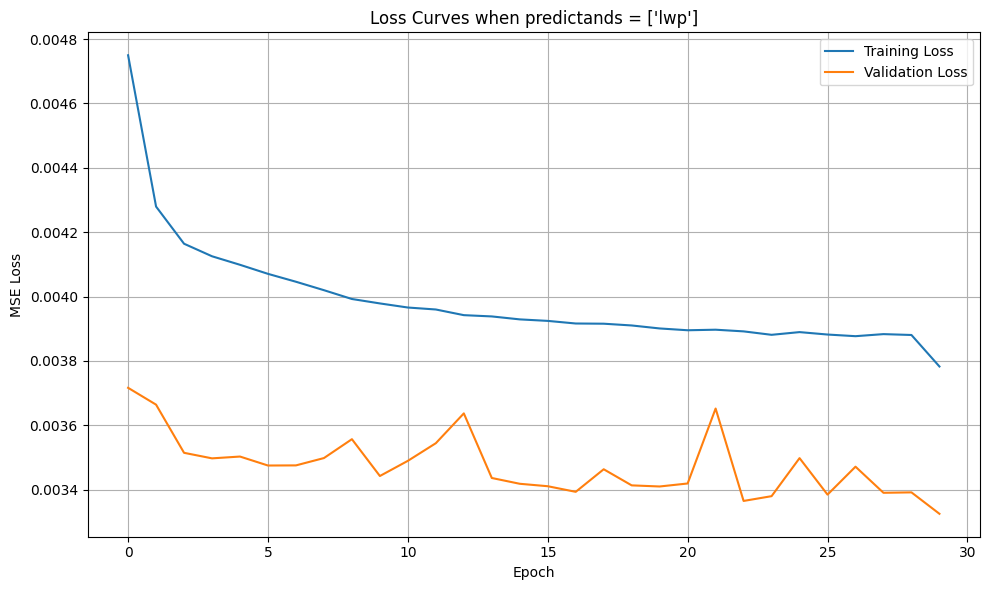

Train Loss: 0.0047 → 0.0038 (20.4% decrease)
Val Loss: 0.0037 → 0.0033 (10.5% decrease)

Final Model Evaluation:
MSE: 0.0066
RMSE: 0.0815
MAE: 0.0613
R²: 0.3181


array([[0.06924305],
       [0.1000113 ],
       [0.07302406],
       ...,
       [0.18739046],
       [0.13100208],
       [0.06619912]], dtype=float32)

In [52]:
 #Visualize training progress
plot_loss_curves(train_losses=train_losses, val_losses=val_losses)

# Final evaluation
evaluate_model(model=model, X_test_tensor=X_test_tensor, y_test=y_test)
#y_pred = evaluate_model(model, X_test_tensor, y_test)

In [44]:
def permutation_feature_importance(model, X, y, metric, n_repeats=5):
    """
    Measures the importance of each input variable by repeatedly shuffling its values in the test data,
    evaluating the increase in prediction error (e.g., MSE). A larger increase means the variable is more important
    for the model's predictions. The process is repeated several times per variable for reliability.
    """

    model.eval()
    # Step 1: Get the model's baseline performance on the unshuffled test data
    with torch.no_grad():
        baseline_predictions = model(X).detach().cpu().numpy()
    if isinstance(y, torch.Tensor):
        y_true = y.cpu().numpy()
    else:
        y_true = y
    baseline_error = metric(y_true, baseline_predictions)
    feature_importances = np.zeros(X.shape[1])

    # Step 2: For each feature, shuffle its values and measure the increase in error
    for feature_idx in range(X.shape[1]):
        shuffled_errors = []
        for _ in range(n_repeats):
            X_shuffled = X.clone()
            shuffle_indices = torch.randperm(X.shape[0])
            X_shuffled[:, feature_idx] = X_shuffled[shuffle_indices, feature_idx]
            with torch.no_grad():
                shuffled_predictions = model(X_shuffled).detach().cpu().numpy()
            shuffled_error = metric(y_true, shuffled_predictions)
            shuffled_errors.append(shuffled_error)
        # Step 3: Calculate importance as the average increase in error due to shuffling this feature
        feature_importances[feature_idx] = np.mean(shuffled_errors) - baseline_error
    # Return both importances and baseline error for percentage calculation
    return feature_importances, baseline_error



Permutation Feature Importances: Predictand  - ['lwp']  (higher = more important):
rh850: 0.0061 (Error Increase: 92.11%)
tcwv: 0.0024 (Error Increase: 36.10%)
t850: 0.0021 (Error Increase: 31.90%)
q850: 0.0021 (Error Increase: 31.35%)
blh: 0.0016 (Error Increase: 24.17%)
eis: 0.0014 (Error Increase: 21.26%)
lnNd: 0.0013 (Error Increase: 19.56%)
sst: 0.0011 (Error Increase: 16.54%)
mlspf: 0.0008 (Error Increase: 12.24%)
q700: 0.0007 (Error Increase: 11.16%)
u850: 0.0005 (Error Increase: 7.43%)
u10: 0.0005 (Error Increase: 7.04%)
msshf: 0.0004 (Error Increase: 6.24%)
v10: 0.0004 (Error Increase: 6.21%)
cape: 0.0004 (Error Increase: 5.55%)
t700: 0.0003 (Error Increase: 4.46%)
v850: 0.0003 (Error Increase: 4.08%)
mslhf: 0.0002 (Error Increase: 2.83%)
Terra_descending: 0.0002 (Error Increase: 2.69%)
w850: 0.0002 (Error Increase: 2.42%)
u700: 0.0001 (Error Increase: 1.93%)
rh700: 0.0001 (Error Increase: 1.28%)
v700: 0.0000 (Error Increase: 0.66%)
w700: 0.0000 (Error Increase: 0.16%)
lsm: 0

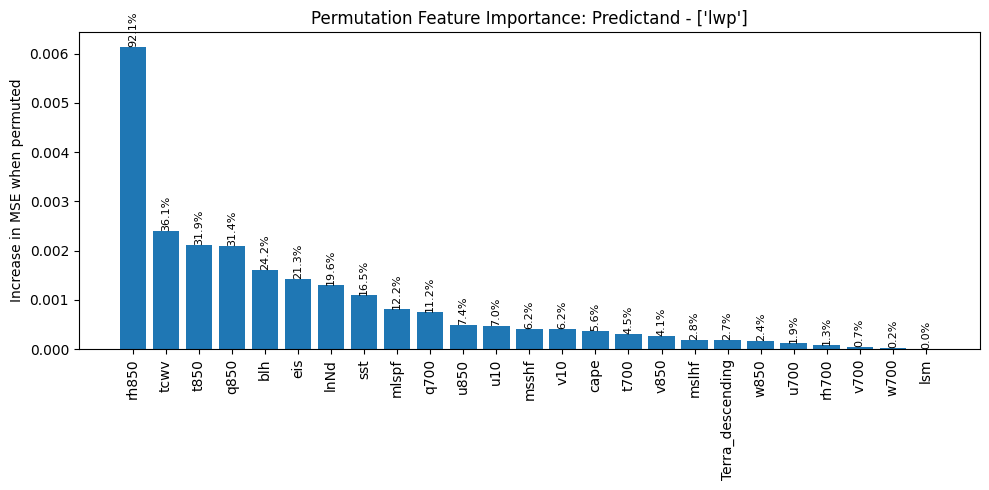

In [45]:
       # Calculate and display feature importances after model evaluation
importances, baseline_error = permutation_feature_importance(
    model, X_test_tensor, y_test.values, mean_squared_error, n_repeats=5
)
# Calculate percentage increase for each feature
percent_increase = 100 * importances / baseline_error
# Sort and print
sorted_idx = np.argsort(importances)[::-1]

print(f"\nPermutation Feature Importances: Predictand  - {predictands}  (higher = more important):")
for i in sorted_idx:
    print(f"{predictors[i]}: {importances[i]:.4f} (Error Increase: {percent_increase[i]:.2f}%)")

# Optionally, plot the importances
plt.figure(figsize=(10, 5))
bars = plt.bar([predictors[i] for i in sorted_idx], importances[sorted_idx])
plt.xticks(rotation=90)
plt.ylabel('Increase in MSE when permuted')
plt.title(f'Permutation Feature Importance: Predictand - {predictands}')
plt.tight_layout()
# Annotate bars with percentage increase
for bar, perc in zip(bars, percent_increase[sorted_idx]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{perc:.1f}%',
             ha='center', va='bottom', fontsize=8, rotation=90)
plt.show()

Partial Dependence Plots

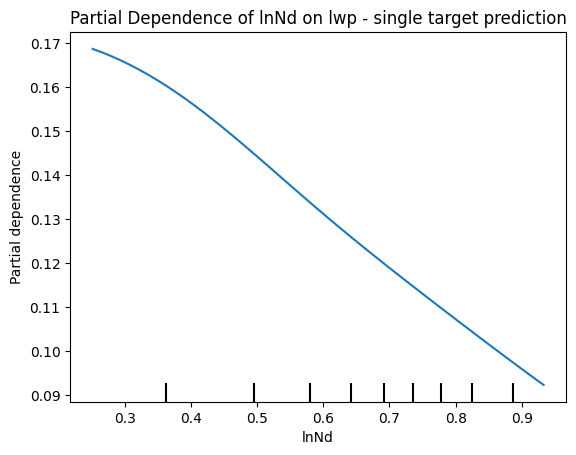

In [46]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define a wrapper for your PyTorch model
class TorchModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.is_fitted_ = True  # Mark as fitted by default
    def fit(self, X, y=None):
        # Dummy fit method for sklearn compatibility
        self.is_fitted_ = True  # Set attribute to pass sklearn's check_is_fitted
        return self
    def predict(self, X):
        """
        Predict method for scikit-learn compatibility.
        For multi-output models, returns the first output column (e.g., CLF) by default.
        To plot for LWP instead of CLF, change 'return preds[:, 0]' to 'return preds[:, 1]'.
        """
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            preds = self.model(X_tensor).cpu().numpy()
        return preds[:, 0]  # Change to preds[:, 1] for LWP

# Instantiate the wrapper
wrapped_model = TorchModelWrapper(model)

# Make sure X_test is a numpy array
if hasattr(X_test, "values"):
    X_test_np = X_test.values
else:
    X_test_np = np.array(X_test)

# Find the index of 'lnNd' in your predictors list
lnNd_idx = predictors.index('lnNd')

# Plot partial dependence for lnNd (for CLF, i.e., output 0)
PartialDependenceDisplay.from_estimator(
    wrapped_model,
    X_test_np,
    features=[lnNd_idx],
    feature_names=predictors,
    grid_resolution=50
)
# Dynamically set the title based on the selected output
output_name = predictands[0] if isinstance(predictands, list) else predictands
plt.title(f"Partial Dependence of lnNd on {output_name} - single target prediction")
plt.show()

